# Numba Stencil


Operasi stencil https://www.mathworks.com/help/parallel-computing/stencil-operations-on-a-gpu.html biasanya digunakan pada metode finite differences, finite elements, atau metode lain yang memanfaatkan suatu mesh atau grid.

## Persamaan Panas 1D

$$
\frac{\partial u}{\partial t} = \alpha \frac{\partial^2 u}{\partial x^2}, \hspace{1em} x \in (0,L), t \in (0, T]
$$

dengan inisial awal $u(x,0) = I_0(x)$ dan syarat batas $u(0,t) = 0$ dan $u(L,t) = 0$.

Masalah ini dapat kita selesaikan dengan mendiskritisasi ruang dan waktunya (disebut juga dengan **metode finite difference**):

* **space discretisation:** $x_i = i\Delta x, i = 0, 1, \cdots, N_x$.
* **time discretisation:** $t_n = n\Delta t, t = 0, 1, \cdots, N_t$

dengan menggunakan **Central Time Central Space (CTCS)** atau dikenal sebagai metode **Crank-Nicolson 1D**

$$
\frac{w_i^{n+1} - w_i^n}{\Delta t} = \alpha \frac{w_{i+1}^n - 2w_i^n + w_{i-1}^n}{\Delta x^2}
$$

sehingga memebentuk

$$
w_i^{n+1} = w_i^n + F(w_{i+1}^n - 2w_i^n + w_{i-1}^n)
$$

dimana $F = \alpha \frac{\Delta t}{\Delta x^2}$.


![](../images/Heat1D.jpg)

Di dalam perhitungan grid terdapat $w_{i-1}, w_i, w_{i+1}$ yang disebut sebagai **3-titik stencil**.

![](../images/Stencil1D.jpg)

### Implementasi

In [1]:
import numba
import numpy as np
import matplotlib.pyplot as plt

In [19]:
Nx = 500
Nt = 10_000
T = 100.
L = 100.

dx = L/Nx
dt = T/Nt
alpha = 1.0
F = alpha * dt/dx*dx

x = np.linspace(0, L, Nx+1)

# nilai awal: sin(2*pi*x) dimana 50 <= x <= 60
temp_awal = np.zeros(Nx+1)
temp_awal[Nx//2:Nx//2+Nx//10] = np.sin(2.0 * np.pi * (x[Nx//2:Nx//2+Nx//10] - x[Nx//2]) / (L/5) )

In [20]:
@numba.stencil
def Crank_Nicolson(x, F):
    return x[0] + F * (x[1] - 2.0 * x[0] + x[-1])

In [21]:
@numba.njit
def simulasi(x, F, Nt):
    for i in range(Nt):
        x = Crank_Nicolson(x, F)
    
    return x

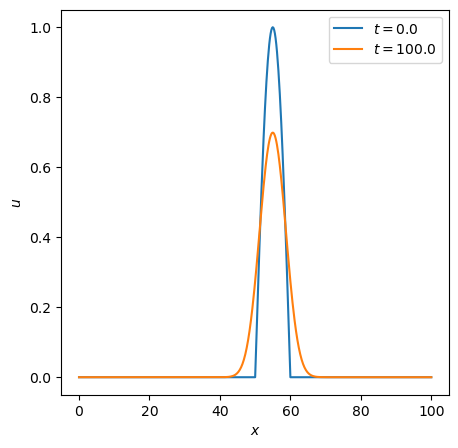

In [22]:
temp_simulasi = simulasi(temp_awal, F, Nt)

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.set_xlabel('$x$')
ax.set_ylabel('$u$')

ax.plot(x, temp_awal, label='$t = 0.0$')
ax.plot(x, temp_simulasi, label=f'$t = {T}$')

ax.legend()
plt.show()

### Widgets (Extra)

In [23]:
import ipywidgets as widgets
from ipywidgets import HBox, VBox
from IPython.display import display

In [27]:
@widgets.interact(T=(1,1000))
def interaksi(T):
    x = np.linspace(0, L, Nx+1)
    
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u$')

    ax.plot(x, temp_awal, label='$t = 0.0$')
    ax.plot(x, simulasi(temp_awal, F, int(T/dt)), label=f'$t = {T}$')

    ax.legend()

interactive(children=(IntSlider(value=500, description='T', max=1000, min=1), Output()), _dom_classes=('widget…

### Analisa Performa

**Python vs NumPy vs Numba**

In [ ]:
%time simulasi(temp_awal, F, Nt)

## Persamaan Panas 2D